# Detectar anomalias

- Ejercicio realizado con RIPS de procedimientos (archivo RIPS AP)
- filtro por prestador
- query: exporte_por_prestador.sql


### Librerias

In [1]:
#!pip install pandas tqdm
#!pip install awswrangler
#!pip install "../../anomaly_tesis_library/whl/lib_anomaly-0.1-py2.py3-none-any.whl" --force-reinstall
#!pip install "D:\OneDrive - Universidad Tecnológica de Bolívar\TesisAnomDetect\anomaly_tesis_library\whl\lib_anomaly-0.1-py2.py3-none-any.whl"
#!pip install -U numpy
#!pip install -U numba

In [2]:
## Librerias necesarias 

import time
start_i = time.time()

import datetime, os, gc

import pandas as pd
import awswrangler as wr
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from lib_anomaly.utils          import get_data_types

from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from sklearn.decomposition      import PCA as pca_

from category_encoders.binary   import BinaryEncoder

from pyod.models.pca            import PCA
from pyod.models.lof            import LOF
from pyod.models.iforest        import IForest
from pyod.models.auto_encoder   import AutoEncoder

from lib_anomaly.anomaly        import make_hidden_layers
from lib_anomaly.utils          import get_data_types

In [3]:
pd.options.display.max_columns = 200

## Clases

In [4]:
class PreprocessPipeline:
    """Preprocessing pipeline for numerical and categorical data."""
    
    def __init__(self, **kwargs):
        """
        Initialize the preprocessing pipeline.
        
        Args:
            numerical_cols (list): List of column names for numerical features.
            categorical_cols (list): List of column names for categorical features.
        """
        ## parametros
        try:
            self.numerical_cols = kwargs["numerical_cols"]
        except:
            self.numerical_cols = list()
        try:
            self.categorical_cols = kwargs["categorical_cols"]
        except:
            self.categorical_cols = list()
        try:
            self.categorical_cols_high = kwargs["categorical_cols_high"]
        except:
            self.categorical_cols_high = list()
        try:
            self.n_components = kwargs["n_components"]
        except:
            self.n_components = list()

        self.preporcessor = self._make_preprocessor()

    def _make_preprocessor(self):
        numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
            , ('scaler', MinMaxScaler((0,1)))
        ])
        categorical_pipeline = Pipeline([
            ('pd.NA', SimpleImputer(missing_values=pd.NA, strategy='most_frequent'))
            , ('np.nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
            , ('None', SimpleImputer(missing_values=None, strategy='most_frequent'))
            , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
        preprocessor_pipe = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, self.numerical_cols)
                , ('cat', categorical_pipeline, self.categorical_cols)
            ])
        return preprocessor_pipe

    def transform(self, data):
        transformed_data = self.preporcessor.fit_transform(data)
        transformed_data = pd.DataFrame(transformed_data, columns=self.preporcessor.get_feature_names_out())
        # transformed_data = self.transform_cols_high(transformed_data, categorical_cols_high)
        df_pca = pd.DataFrame()
        for c in self.categorical_cols_high:
            busq = f"cat__{c}_"
            cols = [c for c in transformed_data if c.startswith(busq)]
            print(f"{busq=}, {len(cols)=}")
            aa = pca_(n_components=self.n_components).fit_transform(transformed_data[cols])
            aa = pd.DataFrame(aa, index=transformed_data.index, columns=[f"{c}__PC{str(i+1).zfill(2)}" for i in range(self.n_components)])
            df_pca = pd.concat([df_pca, aa], axis=1)
            print(f"{aa.shape=}")
            transformed_data = transformed_data.drop(cols, axis=1)
            print(f"{transformed_data.shape=}")
        df_pca = pd.DataFrame(MinMaxScaler((0,1)).fit_transform(df_pca), index=df_pca.index, columns=df_pca.columns)
        transformed_data = pd.concat([transformed_data,df_pca], axis=1)
        return transformed_data

    

## Funciones

In [5]:
def load_data(k:str, make:bool=False, debug:bool=False):
    fName = f"./data/{k.lower()}.parquet"
    try:
        if make==True: raise Exception("make==True")
        data_raw = pd.read_parquet(fName)
    except:
        sql = open(f"./querys/{k}.sql", mode="r", encoding="utf8").read()
        data_raw = wr.athena.read_sql_query(sql=sql, database="default")
        try:
            data_raw["edad"] = data_raw["edad"].astype(int)
        except:
            pass
        data_raw = data_raw.set_index("id")
        data_raw.to_parquet(fName)
    if debug==True: print(f"{data_raw.shape=}")
    return data_raw

In [6]:
def drop_vars_1(data:pd.DataFrame):
    cols_to_drop = list(data.nunique()[data.nunique()==1].index)
    print(f"{cols_to_drop=}")
    return data.drop(cols_to_drop,axis=1)

In [7]:
def get_table_stats(df:pd.DataFrame):
    colums_stats = pd.concat([df.dtypes, df.nunique(), df.isnull().sum(), (df.isnull().sum()/len(df))], axis=1)
    colums_stats.columns = ["dtypes", "nunique","nulls","%nulls"]
    return colums_stats

In [8]:
def prepare_data(data_raw:pd.DataFrame, features:list=list(), cols_2_drop:list=list()):
    
    data = data_raw.copy()
    
    ## drop useless cols
    cols_2_drop = cols_2_drop + ["id_persona","fecha"]
    for c in cols_2_drop:
        try:
            data = data.drop(c,axis=1)
        except:
            pass

    ## drop vars with only one nunique data
    data = drop_vars_1(data=data)

    ## bool data to numeric
    cols_bool = data.select_dtypes("bool").columns
    data[cols_bool] = data[cols_bool].apply(lambda x: x.map({True:1, False:0})).fillna(0)
    
    if len(features)>0:
        data = data[features]
    
    return data

Anomaly

In [9]:
def get_dtypes(data:pd.DataFrame, debug:bool=False):
    numerical_cols = list(data.select_dtypes(include=['number']).columns)
    categorical_cols = list(data.select_dtypes(exclude=['number']).columns)
    if debug==True: print(f"{numerical_cols=}\n{categorical_cols=}")
    categorical_cols_high = list(data[categorical_cols].nunique()[data[categorical_cols].nunique()>15].index)
    if "departamento" in categorical_cols_high:
        categorical_cols_high = [c for c in categorical_cols_high if c!="departamento"]
    categorical_cols_low  = [c for c in categorical_cols if c not in categorical_cols_high]
    if debug==True: print(f"{categorical_cols_high=}\n{categorical_cols_low=}")
    return numerical_cols, categorical_cols, categorical_cols_high, categorical_cols_low

In [10]:
def make_ensamble(df:pd.DataFrame, anomaly_methods:list, anomaly_threshold:float, debug:bool=False):
    
    ### Ensamble
    name_detector = "Ensamble"
    df[name_detector] = df[anomaly_methods].sum(axis=1)
    df[name_detector+"__prob"] = df[[c+"__prob" for c in anomaly_methods]].mean(axis=1)
    df[name_detector+"__prob_std"] = df[[c+"__prob" for c in anomaly_methods]].std(axis=1)
    # anom__prob = data[name_detector+"__prob"].reset_index(drop=True).values
    # anom_index = [i for i,a in enumerate(data[name_detector+"__prob"]) if a>data[name_detector+"__prob"].quantile(1-contamination)]
    # df.loc[:,"LOF":].describe().T
    
    # make_ensamble_anomaly_detector_by_threshold
    name_detector = f"Ensamble P({anomaly_threshold})"
    df[name_detector] = df["Ensamble__prob"]>anomaly_threshold
    df[name_detector] = df[name_detector].astype(int)
    
    # ensamble wiith treshold
    name_detector = f"Ensamble P({anomaly_threshold})"
    df[name_detector] = df["Ensamble__prob"]>anomaly_threshold
    df[name_detector] = df[name_detector].astype(int)
    
    return df

In [11]:
def make_position(df:pd.DataFrame, anomaly_methods:list):
    df = df.reset_index()
    for met in anomaly_methods+["Ensamble"]:
        try:
            df = df.sort_values(met+"__score", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index":met+"__pos"})
        except:
            df = df.sort_values(met+"__prob", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index":met+"__pos"})
    cols = [c for c in df if c.endswith("__pos")]
    df[cols] = df[cols] + 1
    df = pd.concat([df.drop(cols, axis=1), df[cols]], axis=1).set_index("id")
    return df

In [12]:
def run_anomaly_detectors(data:pd.DataFrame, X:np.ndarray, anomaly_methods:list, contamination:float, anomaly_threshold:float, debug:bool=False):
    """
        Ejecuta la deteccion de las anomalias a traves de los metodos pasados
        Arroja si el registro es marcado como anomalo o no, al igual que la probabilidad
    """
    data = data.copy()
    for name_detector in anomaly_methods:
        start = time.time()
        if debug==True: print(f"**************\nstarting: {name_detector}, {contamination=}")
        if name_detector=="AutoEncoder":
            nn_layers = make_hidden_layers(no_features=X.shape[1])
            detector = eval(f"{name_detector}(hidden_neurons={nn_layers}, verbose=0, contamination={contamination})")
        else:
            detector = eval(f"{name_detector}(contamination={contamination})")
        detector.fit(X)
        data[name_detector] = detector.labels_
        data[f"{name_detector}__score"] = detector.decision_function(X)
        data[f"{name_detector}__prob"]  = detector.predict_proba(X)[:,1]
        if debug==True: print(f"No of anomaly = {sum(data[name_detector])}({round(sum(data[name_detector])/len(data[name_detector])*100,4)}%)")
        if debug==True: print(f"anom distribution; {dict(data[name_detector].value_counts().sort_index())}, {dict(data[name_detector].value_counts(normalize=True).sort_index())}")
        if debug==True: print(f"Run: {(time.time()-start)/60:.2f} min.")
    gc.collect()
    
    df = make_ensamble(
                    df=data
                    , anomaly_methods=anomaly_methods
                    , anomaly_threshold=anomaly_threshold
                    , debug=debug
                )
    df = make_position(
                    df=df
                    , anomaly_methods=anomaly_methods
                )
    return df

In [13]:
def save_output(df:pd.DataFrame, path:str=None, **kwargs):
    if path==None:
        fpath = f"./output/{path}/"
    else:
        fpath = f"./output/"
    try:
        os.makedirs(fpath)
    except:
        pass
    
    try:
        fName = f"{fpath}{kwargs['anno']}{str(kwargs['mes']).zfill(2)}.parquet"    
    except:
        fName = f"{fpath}{path}.parquet"
        
    df.to_parquet(fName)
    
    return fName

In [14]:
def get_stats(df:pd.DataFrame):
    colums_stats = pd.concat([df.dtypes, df.count(), df.nunique(), df.isnull().sum(), (df.isnull().sum()/len(df))], axis=1)
    colums_stats.columns = ["dtypes", "#reg", "nunique","nulls","%nulls"]
    colums_stats = pd.concat([colums_stats, df.describe().T], axis=1)
    return colums_stats

## Obtener datos

#### Params

In [15]:
feat = [
        # 'prestador', 'id_persona',
        #, 'tipo_identificacion', 'tipo_usuario',
        'edad'
        , 'sexo'
        , 'departamento', 'zona'
        #, 'fecha',
        # 'anno', 'mes',
        #'servicio', 'servicio_desc', 
        , 'servicio_capitulo_cups'
        #'ambito', 'finalidad',
        #'dx_ppal', 'dx_ppal_desc', 'dx_ppal_capitulo',
        #'cie10_3dig',
        , 'cie10_3dig_desc'
        , 'dx_rel_mismo_capitulo', 'dx_complicacion_mismo_capitulo'
        #, 'forma_realizacion_actoqx'
        , 'valor', 'medicamentos'
        , 'dias_ult_procedimiento', 'dx_ult_proced'
]
print(f"{len(feat)=}")

len(feat)=12


In [16]:
contamination:float=0.01
anomaly_methods:list=["LOF", "IForest", "AutoEncoder"]
anomaly_threshold:float=0.3
n_components:int=2
k = "procedimientos_prestador"
debug:bool=True

#### RAW data

In [17]:
%%time
data_raw = load_data(
                        k=k
                        , make=True
                        , debug=debug
                )
data_raw.head()

data_raw.shape=(233739, 32)
CPU times: total: 14.6 s
Wall time: 31.6 s


,factura,prestador,id_persona,tipo_identificacion,regimen,tipo_usuario,edad,sexo,departamento,zona,fecha,anno,mes,servicio,servicio_desc,servicio_seccion_cups,servicio_capitulo_cups,ambito,finalidad,dx_ppal,dx_ppal_desc,dx_ppal_capitulo,cie10_3dig,cie10_3dig_desc,dx_rel_mismo_capitulo,dx_complicacion_mismo_capitulo,forma_realizacion_actoqx,valor,medicamentos,dias_ult_procedimiento,dx_ult_proced,dx_ult_proced_3dig
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24535616,0C31F0EAC8C7F7B6D3328E7658D4F622,517E624BC8E440922E3B77053E805428,34DE3E22D0853B8ED30E3C126891E557,CC,1,2. Subsidiado,68,0,BOLÍVAR,0,2022-02-15,2022,2,903895,CREATININA EN SUERO U OTROS FLUIDOS,01 PROCEDIMIENTOS NO QUIRURGICOS,17. LABORATORIO CLINICO,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,3095.0,0,0,False,False
29946985,998F6AC2D1142DABD3F9E0E1289DA443,517E624BC8E440922E3B77053E805428,35B1AFE2E92D8AD7D2939603FADA8952,CC,1,2. Subsidiado,51,1,BOLÍVAR,0,2022-06-14,2022,6,903815,COLESTEROL DE ALTA DENSIDAD,01 PROCEDIMIENTOS NO QUIRURGICOS,17. LABORATORIO CLINICO,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,5515.0,0,0,False,False
41703136,191D68A908515909BA4608089D8EB37D,517E624BC8E440922E3B77053E805428,35B1AFE2E92D8AD7D2939603FADA8952,CC,1,2. Subsidiado,50,1,BOLÍVAR,0,2021-08-11,2021,8,881214,ECOCARDIOGRAMA TRANSTORACICO CON ANALISIS DE L...,00 PROCEDIMIENTOS QUIRURGICOS E INTERVENCIONISTAS,15. IMAGENOLOGIA,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,182034.0,0,0,False,False
10020081,68C7B20339689A30BC67D157EC505A7E,517E624BC8E440922E3B77053E805428,35B1AFE2E92D8AD7D2939603FADA8952,CC,1,2. Subsidiado,51,1,BOLÍVAR,0,2022-07-26,2022,7,881214,ECOCARDIOGRAMA TRANSTORACICO CON ANALISIS DE L...,01 PROCEDIMIENTOS NO QUIRURGICOS,15. IMAGENOLOGIA,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,182034.0,0,349,True,True
27906922,2C6C6E06DD0A1CD586CECBD016F42080,517E624BC8E440922E3B77053E805428,5B9BF7CD66965E665023829C030835D1,CC,1,2. Subsidiado,63,0,BOLÍVAR,0,2021-11-26,2021,11,903895,CREATININA EN SUERO U OTROS FLUIDOS,00 PROCEDIMIENTOS QUIRURGICOS E INTERVENCIONISTAS,17. LABORATORIO CLINICO,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,3095.0,0,73,False,False


In [18]:
data_raw[:3].T

id,24535616,29946985,41703136
factura,0C31F0EAC8C7F7B6D3328E7658D4F622,998F6AC2D1142DABD3F9E0E1289DA443,191D68A908515909BA4608089D8EB37D
prestador,517E624BC8E440922E3B77053E805428,517E624BC8E440922E3B77053E805428,517E624BC8E440922E3B77053E805428
id_persona,34DE3E22D0853B8ED30E3C126891E557,35B1AFE2E92D8AD7D2939603FADA8952,35B1AFE2E92D8AD7D2939603FADA8952
tipo_identificacion,CC,CC,CC
regimen,1,1,1
tipo_usuario,2. Subsidiado,2. Subsidiado,2. Subsidiado
edad,68,51,50
sexo,0,1,1
departamento,BOLÍVAR,BOLÍVAR,BOLÍVAR
zona,0,0,0


In [19]:
get_table_stats(df=data_raw)

,dtypes,nunique,nulls,%nulls
factura,string[python],9307,0,0.0
prestador,string[python],1,0,0.0
id_persona,string[python],16235,0,0.0
tipo_identificacion,string[python],11,0,0.0
regimen,Int32,2,0,0.0
tipo_usuario,string[python],5,0,0.0
edad,int32,104,0,0.0
sexo,Int32,2,0,0.0
departamento,string[python],18,0,0.0
zona,Int32,2,0,0.0


<Axes: xlabel='edad'>

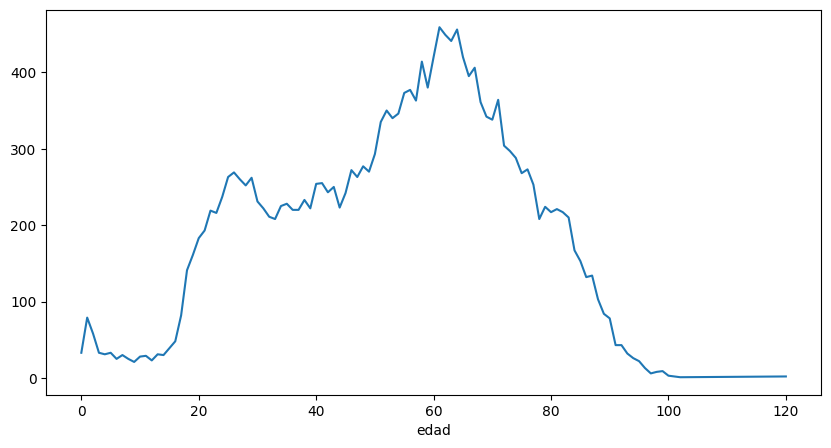

In [20]:
tmp1 = data_raw.reset_index().groupby(["edad"], dropna=False).agg(
                                                reg=("id","size")
                                                , personas=("id_persona","nunique")
                                                , valor=("valor","sum")
                                            ).sort_index()
tmp1["personas"].plot(figsize=(10,5))

## Pre-procesar los datos


### Filtrar los datos

In [21]:
try:
        print("Filtro = ", dict(filtro.value_counts()))
except:
        filtro = None
        print(f"{filtro=}")
print(f"# of features: {len(feat)}")

filtro=None
# of features: 12


In [22]:
try:
    data = data_raw[filtro].copy()
    print("**Filtro aplicado..")
except:
    data = data_raw.copy()
    print("**Igual a data_raw..")

data = data[feat]

data = prepare_data(data_raw=data)

print(f"{data_raw.shape=}\n{data.shape=}")
data.head()

**Igual a data_raw..
cols_to_drop=[]
data_raw.shape=(233739, 33)
data.shape=(233739, 12)


,edad,sexo,departamento,zona,servicio_capitulo_cups,cie10_3dig_desc,dx_rel_mismo_capitulo,dx_complicacion_mismo_capitulo,valor,medicamentos,dias_ult_procedimiento,dx_ult_proced
id,,,,,,,,,,,,
32205063,53,1,BOLÍVAR,0,17. LABORATORIO CLINICO,EXAMEN ESPECIAL NO ESPECIFICADO,0,0,3095.0,6,0,0
33345487,55,1,BOLÍVAR,0,17. LABORATORIO CLINICO,EXAMEN ESPECIAL NO ESPECIFICADO,0,0,3095.0,0,292,1
20161336,67,0,BOLÍVAR,0,15. IMAGENOLOGIA,EXAMEN ESPECIAL NO ESPECIFICADO,0,0,1200000.0,0,0,0
21299466,52,1,BOLÍVAR,0,17. LABORATORIO CLINICO,EXAMEN ESPECIAL NO ESPECIFICADO,0,0,3665.0,0,409,0
74383471,54,0,BOLÍVAR,0,17. LABORATORIO CLINICO,EXAMEN ESPECIAL NO ESPECIFICADO,0,0,265380.0,19,0,0


Estadisticas del dataframe resultante

In [23]:
colums_stats = get_stats(data)
colums_stats

,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
edad,int32,233739,104,0,0.0,233739.0,57.488134,18.728472,0.0,45.0,61.0,71.0,120.0
sexo,Int32,233739,2,0,0.0,233739.0,0.576682,0.494086,0.0,0.0,1.0,1.0,1.0
departamento,string[python],233739,18,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zona,Int32,233739,2,0,0.0,233739.0,0.001609,0.040076,0.0,0.0,0.0,0.0,1.0
servicio_capitulo_cups,string[python],233739,23,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cie10_3dig_desc,string[python],233739,554,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dx_rel_mismo_capitulo,int64,233739,2,0,0.0,233739.0,0.000026,0.005066,0.0,0.0,0.0,0.0,1.0
dx_complicacion_mismo_capitulo,int64,233739,2,0,0.0,233739.0,0.000663,0.025743,0.0,0.0,0.0,0.0,1.0
valor,float64,233739,3050,0,0.0,233739.0,47833.232593,381356.900392,1330.0,4581.0,10280.0,21760.0,50985231.0
medicamentos,Int64,233739,73,0,0.0,233739.0,14.08622,14.481123,0.0,3.0,10.0,21.0,103.0


### Realizar transformaciones de variables

In [24]:
print(f"Input data = {data.shape}")
numerical_cols, categorical_cols, categorical_cols_high, categorical_cols_low = get_dtypes(
                                                                                            data=data
                                                                                            , debug=debug
                                                                                        )


Input data = (233739, 12)
numerical_cols=['edad', 'sexo', 'zona', 'dx_rel_mismo_capitulo', 'dx_complicacion_mismo_capitulo', 'valor', 'medicamentos', 'dias_ult_procedimiento', 'dx_ult_proced']
categorical_cols=['departamento', 'servicio_capitulo_cups', 'cie10_3dig_desc']
categorical_cols_high=['servicio_capitulo_cups', 'cie10_3dig_desc']
categorical_cols_low=['departamento']


In [25]:
PrePipeline = PreprocessPipeline(
                                    numerical_cols=numerical_cols
                                    , categorical_cols=categorical_cols
                                    , categorical_cols_high=categorical_cols_high
                                    , n_components=n_components
                                )
transformed_data = PrePipeline.transform(data)
transformed_data

busq='cat__servicio_capitulo_cups_', len(cols)=23
aa.shape=(233739, 2)
transformed_data.shape=(233739, 581)
busq='cat__cie10_3dig_desc_', len(cols)=554
aa.shape=(233739, 2)
transformed_data.shape=(233739, 27)


,num__edad,num__sexo,num__zona,num__dx_rel_mismo_capitulo,num__dx_complicacion_mismo_capitulo,num__valor,num__medicamentos,num__dias_ult_procedimiento,num__dx_ult_proced,cat__departamento_AMAZONAS,cat__departamento_ANTIOQUIA,cat__departamento_ATLÁNTICO,cat__departamento_BOLÍVAR,cat__departamento_BOYACÁ,cat__departamento_CALDAS,cat__departamento_CASANARE,cat__departamento_CAUCA,cat__departamento_CESAR,cat__departamento_CHOCÓ,cat__departamento_CÓRDOBA,cat__departamento_HUILA,cat__departamento_LA GUAJIRA,cat__departamento_MAGDALENA,cat__departamento_NARIÑO,cat__departamento_PUTUMAYO,cat__departamento_SUCRE,cat__departamento_TOLIMA,servicio_capitulo_cups__PC01,servicio_capitulo_cups__PC02,cie10_3dig_desc__PC01,cie10_3dig_desc__PC02
0,0.441667,1.0,0.0,0.0,0.0,0.000035,0.058252,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.427053,1.0,1.000000
1,0.458333,1.0,0.0,0.0,0.0,0.000035,0.000000,0.271123,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.523360e-15,0.427053,1.0,1.000000
2,0.558333,0.0,0.0,0.0,0.0,0.023511,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000,1.0,1.000000
3,0.433333,1.0,0.0,0.0,0.0,0.000046,0.000000,0.379759,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,1.0,1.000000
4,0.450000,0.0,0.0,0.0,0.0,0.005179,0.184466,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233734,0.466667,0.0,0.0,0.0,0.0,0.000244,0.330097,0.002786,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,0.0,0.442451
233735,0.466667,0.0,0.0,0.0,0.0,0.000244,0.330097,0.000929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,0.0,0.442451
233736,0.466667,0.0,0.0,0.0,0.0,0.000244,0.330097,0.000929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,0.0,0.442451
233737,0.466667,0.0,0.0,0.0,0.0,0.000244,0.330097,0.000929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.495604e-15,0.427053,0.0,0.442451


In [26]:
get_stats(df=transformed_data)

,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
num__edad,float64,233739,104,0,0.0,233739.0,0.479068,0.156071,0.0,3.750000e-01,5.083333e-01,5.916667e-01,1.0
num__sexo,float64,233739,2,0,0.0,233739.0,0.576682,0.494086,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.0
num__zona,float64,233739,2,0,0.0,233739.0,0.001609,0.040076,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
num__dx_rel_mismo_capitulo,float64,233739,2,0,0.0,233739.0,0.000026,0.005066,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
num__dx_complicacion_mismo_capitulo,float64,233739,2,0,0.0,233739.0,0.000663,0.025743,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
num__valor,float64,233739,3050,0,0.0,233739.0,0.000912,0.007480,0.0,6.376523e-05,1.755456e-04,4.007147e-04,1.0
num__medicamentos,float64,233739,73,0,0.0,233739.0,0.136759,0.140593,0.0,2.912621e-02,9.708738e-02,2.038835e-01,1.0
num__dias_ult_procedimiento,float64,233739,899,0,0.0,233739.0,0.023643,0.079453,0.0,0.000000e+00,9.285051e-04,2.785515e-03,1.0
num__dx_ult_proced,float64,233739,2,0,0.0,233739.0,0.377541,0.484773,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.0
cat__departamento_AMAZONAS,float64,233739,2,0,0.0,233739.0,0.000051,0.007165,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0


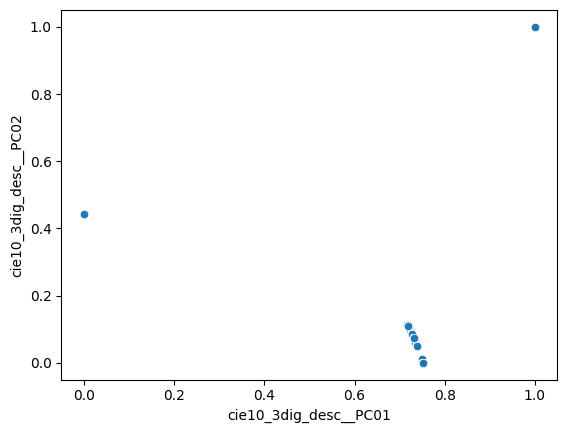

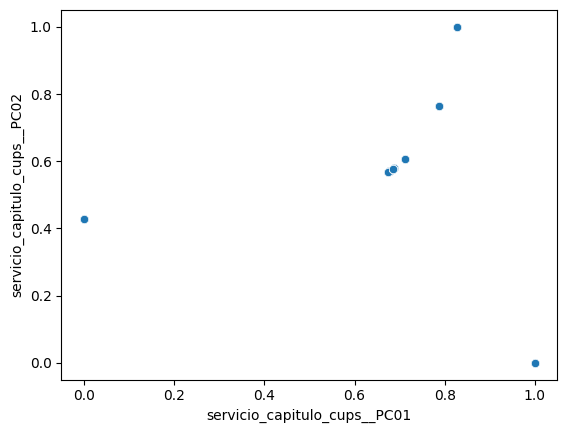

In [27]:
sns.scatterplot(transformed_data, x="cie10_3dig_desc__PC01", y="cie10_3dig_desc__PC02")
plt.show()

sns.scatterplot(transformed_data, x="servicio_capitulo_cups__PC01", y="servicio_capitulo_cups__PC02")
plt.show()

In [28]:
transformed_data.iloc[0]

num__edad                              0.441667
num__sexo                              1.000000
num__zona                              0.000000
num__dx_rel_mismo_capitulo             0.000000
num__dx_complicacion_mismo_capitulo    0.000000
num__valor                             0.000035
num__medicamentos                      0.058252
num__dias_ult_procedimiento            0.000000
num__dx_ult_proced                     0.000000
cat__departamento_AMAZONAS             0.000000
cat__departamento_ANTIOQUIA            0.000000
cat__departamento_ATLÁNTICO            0.000000
cat__departamento_BOLÍVAR              1.000000
cat__departamento_BOYACÁ               0.000000
cat__departamento_CALDAS               0.000000
cat__departamento_CASANARE             0.000000
cat__departamento_CAUCA                0.000000
cat__departamento_CESAR                0.000000
cat__departamento_CHOCÓ                0.000000
cat__departamento_CÓRDOBA              0.000000
cat__departamento_HUILA                0

## Obtener anomalias

Se aplica la metodologia para obtener las anomalias.

In [29]:
%%time

## run detector
df_anom = run_anomaly_detectors(
        data=data
        , X=transformed_data.values
        , anomaly_methods=anomaly_methods
        , contamination=contamination
        , anomaly_threshold=anomaly_threshold
)


7305/7305 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
7305/7305 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7305/7305 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
CPU times: total: 1h 38min 57s
Wall time: 32min 21s


In [23]:
## concat with input
cols1 = [c for c in df_anom if c not in data_raw]
cols2 = [c for c in data if c not in list(data_raw.columns)+cols1]

df = pd.concat([
                data_raw.loc[df_anom.index].sort_index()
                , df_anom[cols1].sort_index()
                , data[cols2].sort_index()
            ], axis=1)

cols = list()
for a in anomaly_methods+["Ensamble"]:
    cols = cols + [c for c in df if c not in data_raw and a in c]
df = df[list(data_raw.columns) + cols]

## all to lower
df.columns = df.columns.str.lower()

print(f"{df.shape=}")

df.head()

df.shape=(233739, 50)


,id,factura,prestador,id_persona,tipo_identificacion,regimen,tipo_usuario,edad,sexo,departamento,zona,fecha,anno,mes,servicio,servicio_desc,servicio_seccion_cups,servicio_capitulo_cups,ambito,finalidad,dx_ppal,dx_ppal_desc,dx_ppal_capitulo,cie10_3dig,cie10_3dig_desc,dx_rel_mismo_capitulo,dx_complicacion_mismo_capitulo,forma_realizacion_actoqx,valor,medicamentos,dias_ult_procedimiento,dx_ult_proced,dx_ult_proced_3dig,lof,lof__score,lof__prob,lof__pos,iforest,iforest__score,iforest__prob,iforest__pos,autoencoder,autoencoder__score,autoencoder__prob,autoencoder__pos,ensamble,ensamble__prob,ensamble__prob_std,ensamble p(0.3),ensamble__pos
0,123,78077796CA71BD47C783E462CA3D15F3,517E624BC8E440922E3B77053E805428,90DBB3B6D7C262F8CAE7801174F15E92,CC,1,2. Subsidiado,44,1,BOLÍVAR,0,2021-10-11,2021,10,911022,PRUEBA CRUZADA MAYOR ERITROCITARIA EN TUBO,00 PROCEDIMIENTOS QUIRURGICOS E INTERVENCIONISTAS,18. MEDICINA TRANSFUSIONAL Y BANCO DE SANGRE,3. Urgencias,1. Diagnostico,R509,"FIEBRE, NO ESPECIFICADA","18. SINTOMAS, SIGNOS Y HALLAZGOS ANORMALES CLI...",R50,OTRAS FIEBRES ESPECIFICADAS,False,False,1. Unilateral,16506.0,2,0,False,False,0,1.006317,1.412325e-11,127009,0,-0.121920,0.342600,64565,0,3.355192,0.003891,65765,0,0.115497,0.196686,0,64770
1,383,6F71B6BF8BCB692BF1A2C6D6C93D044B,517E624BC8E440922E3B77053E805428,E8EC3B5EA2C69E7DD1AD982BEBB3E587,CC,1,2. Subsidiado,65,1,BOLÍVAR,0,2022-09-20,2022,9,903895,CREATININA EN SUERO U OTROS FLUIDOS,01 PROCEDIMIENTOS NO QUIRURGICOS,17. LABORATORIO CLINICO,3. Urgencias,1. Diagnostico,K352,APENDICITIS AGUDA CON PERITONITIS GENERALIZADA,11. ENFERMEDADES DEL SISTEMA DIGESTIVO (K00-K93),K35,APENDICITIS AGUDA CON PERITONITIS GENERALIZADA,False,False,1. Unilateral,3869.0,24,88,False,False,0,1.279323,3.342763e-11,57137,0,-0.147923,0.266709,83434,0,2.309592,0.001723,145582,0,0.089477,0.153489,0,84209
2,1192,A560E4BC3075D0A8655F62E3B5012C0D,517E624BC8E440922E3B77053E805428,12490D42A690B1160B4AA9F2A6A2E777,CC,1,1. Contributivo,65,0,BOLÍVAR,0,2022-10-20,2022,10,903605,IONOGRAMA CLORO SODIO POTASIO Y BICARBONATO O ...,01 PROCEDIMIENTOS NO QUIRURGICOS,17. LABORATORIO CLINICO,3. Urgencias,1. Diagnostico,I10X,HIPERTENSION ESENCIAL (PRIMARIA),09. ENFERMEDADES DEL SISTEMA CIRCULATORIO (I00...,I10,HIPERTENSION ESENCIAL (PRIMARIA),False,False,1. Unilateral,27200.0,3,0,False,False,0,1.051611,1.732598e-11,95782,0,-0.183892,0.161734,118220,0,2.493182,0.002104,119725,0,0.054612,0.092776,0,118319
3,1389,78077796CA71BD47C783E462CA3D15F3,517E624BC8E440922E3B77053E805428,90DBB3B6D7C262F8CAE7801174F15E92,CC,1,2. Subsidiado,44,1,BOLÍVAR,0,2021-10-11,2021,10,903044,SATURACION DE TRANSFERRINA,00 PROCEDIMIENTOS QUIRURGICOS E INTERVENCIONISTAS,17. LABORATORIO CLINICO,3. Urgencias,1. Diagnostico,D649,ANEMIA DE TIPO NO ESPECIFICADO,03. ENFERMEDADES DE LA SANGRE Y DE LOS ORGANOS...,D64,OTRAS ANEMIAS ESPECIFICADAS,False,False,1. Unilateral,16506.0,2,0,False,False,0,0.964125,1.113980e-11,226291,0,-0.196441,0.125111,140589,0,2.363500,0.001835,137631,0,0.042315,0.071709,0,140541
4,1427,B487C352FDC5B29A34F44687EDCCB21D,517E624BC8E440922E3B77053E805428,BDBCE645FCB568C4DD37908A6B52C76A,CC,1,2. Subsidiado,55,0,BOLÍVAR,0,2022-08-30,2022,8,881214,ECOCARDIOGRAMA TRANSTORACICO CON ANALISIS DE L...,01 PROCEDIMIENTOS NO QUIRURGICOS,15. IMAGENOLOGIA,1. Ambulatorio,1. Diagnostico,Z019,EXAMEN ESPECIAL NO ESPECIFICADO,21. FACTORES QUE INFLUYEN EN EL ESTADO DE SALU...,Z01,EXAMEN ESPECIAL NO ESPECIFICADO,False,False,1. Unilateral,182034.0,0,0,False,False,0,0.992810,1.316817e-11,180318,0,-0.038191,0.586962,8757,0,4.701006,0.006681,13460,0,0.197881,0.336971,0,8859


In [31]:
# df.describe().T
get_stats(df=df)

,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
factura,string[python],233739,9307,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prestador,string[python],233739,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ips_nom,string[python],233739,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id_persona,string[python],233739,16235,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_identificacion,string[python],233739,11,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regimen,Int32,233739,2,0,0.0,233739.0,0.991058,0.094137,0.0,1.0,1.0,1.0,1.0
tipo_usuario,string[python],233739,5,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
edad,int32,233739,104,0,0.0,233739.0,57.488134,18.728472,0.0,45.0,61.0,71.0,120.0
sexo,Int32,233739,2,0,0.0,233739.0,0.576682,0.494086,0.0,0.0,1.0,1.0,1.0
departamento,string[python],233739,18,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
print(f"""Max value of ensamble__prob = {df["ensamble__prob"].max():,.2%}""")

Max value of ensamble__prob = 83.83%


In [33]:
anomaly_methods

['LOF', 'IForest', 'AutoEncoder']

In [34]:
me = anomaly_methods[0]
df.sort_values(f"{me.lower()}__pos").head()[feat+[c for c in df if c.startswith(me.lower())]].iloc[0]

edad                                                           77
sexo                                                            1
departamento                                                CESAR
zona                                                            0
servicio_capitulo_cups                           15. IMAGENOLOGIA
cie10_3dig_desc                   EXAMEN ESPECIAL NO ESPECIFICADO
dx_rel_mismo_capitulo                                       False
dx_complicacion_mismo_capitulo                              False
valor                                                    182034.0
medicamentos                                                    0
dias_ult_procedimiento                                          0
dx_ult_proced                                               False
lof                                                             1
lof__score                                     13435028843.544403
lof__prob                                                    0.95
lof__pos  

,count,proportion
edad,,
0,127,0.000543
1,383,0.001639
2,237,0.001014
3,168,0.000719
4,152,0.000650
...,...,...
99,162,0.000693
100,8,0.000034
101,18,0.000077


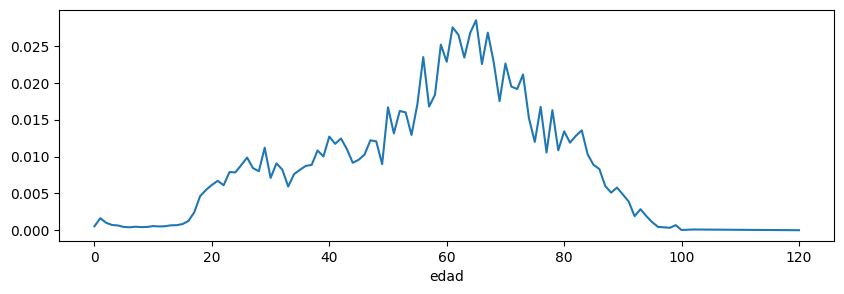

In [35]:
df["edad"].value_counts(normalize=True).sort_index().plot(figsize=(10,3))
pd.concat([df["edad"].value_counts().sort_index(), df["edad"].value_counts(normalize=True).sort_index()], axis=1)


In [36]:
fName = f"./output/{k}.parquet"
df.to_parquet(fName)


# Rev

In [37]:
pd.concat([df["cie10_3dig_desc"].value_counts(), df["cie10_3dig_desc"].value_counts(normalize=True)]
          , axis=1
        ).assign(cum_p=lambda x: x["proportion"].cumsum())

,count,proportion,cum_p
cie10_3dig_desc,,,
DOLOR AGUDO,150075,0.642062,0.642062
EXAMEN ESPECIAL NO ESPECIFICADO,23979,0.102589,0.744651
ABDOMEN AGUDO,4474,0.019141,0.763792
OTROS ESTADOS POSTQUIRURGICOS ESPECIFICADOS,4176,0.017866,0.781658
DOLOR DE GARGANTA,2834,0.012125,0.793783
...,...,...,...
IMPETIGO [CUALQUIER SITIO ANATOMICO] [CUALQUIER ORGANISMO],1,0.000004,0.999983
ABSCESO DEL HIGADO,1,0.000004,0.999987
HERIDA DE LA CADERA,1,0.000004,0.999991


In [38]:
print(f"Tiempo de ejecucion total: {round((time.time()-start_i)/60,2)}min.")
print(f"Fecha de ejecucion: {datetime.datetime.now()}")

Tiempo de ejecucion total: 33.99min.
Fecha de ejecucion: 2024-07-11 09:51:02.777196
